# Regridding

`coecms.regrid.Regridder` provides regridding functionality for xarray DataArrays.

First let's load our libraries and some sample data

In [1]:
%matplotlib inline

from coecms.regrid import Regridder
from coecms import grid

import xarray
import numpy
import matplotlib.pyplot as plt

ds = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-3_historical_r1i1p1_185001-200512.nc',
                         chunks={'time':10})

ds.tas

<xarray.DataArray 'tas' (time: 1872, lat: 145, lon: 192)>
dask.array<shape=(1872, 145, 192), dtype=float32, chunksize=(10, 145, 192)>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-02-05T23:49:51Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

## Target grid

The target grid can be defined in several ways:

 * Using a `coecms.grid.Grid` object
 * Using another `xarray.DataArray` object (reading in the lats and lons)
 * By using weights generated by an external program (e.g. `ESMF_RegridWeightGen`) like 
 
 ```
 r = Regridder(ds.tas, weights=xarray.open_datset('weights.nc'))
 ```
 
Here I'm using a regular Lat-Lon grid. The Regridder object feeds this information into CDO to generate the weights - this may not be a good idea for really big grids!

In [2]:
g = grid.LonLatGrid(lons=numpy.linspace(0, 360, endpoint=False), lats=numpy.linspace(-90,90))
r = Regridder(ds.tas, g)

## Regridding

The `Regridder` will generate and save the regridding weights, so the same weights can be re-used multiple times. Call `Regridder.regrid()` to apply the weights to a dataset.

This is Dask aware, so should work fine for large datasets

In [3]:
tas_regrid = r.regrid(ds.tas)
tas_regrid

<xarray.DataArray 'tas' (time: 1872, i: 50, j: 50)>
dask.array<shape=(1872, 50, 50), dtype=float64, chunksize=(10, 50, 50)>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
    height   float64 ...
    lat      (i) float64 -90.0 -86.33 -82.65 -78.98 -75.31 -71.63 -67.96 ...
    lon      (j) float64 0.0 7.2 14.4 21.6 28.8 36.0 43.2 50.4 57.6 64.8 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-02-05T23:49:51Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

## Checking Results

Plotting the results is a good way to check the regridding is performing correctly

Text(0.5,1,'Regridded')

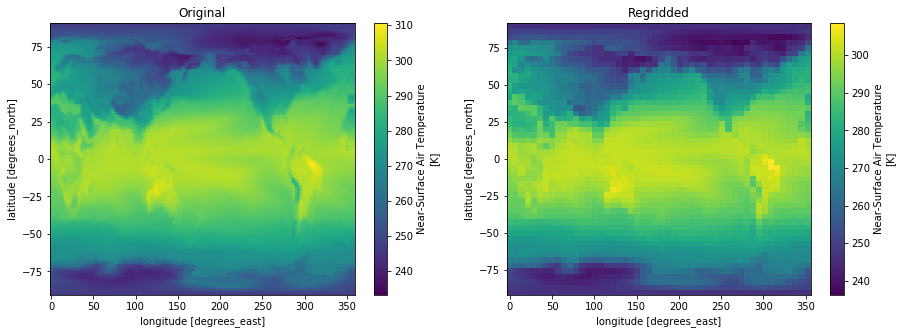

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(121)
ds.tas.isel(time=-1).plot()
plt.title("Original")
plt.subplot(122)
tas_regrid.isel(time=-1).plot.pcolormesh('lon','lat')
plt.title("Regridded")